In [11]:
#Import Necessray Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Load data
center_info = pd.read_csv('fulfilment_center_info.csv')
meal_info = pd.read_csv('meal_info.csv')
test_data = pd.read_csv('genpact_test.csv')
train_data = pd.read_csv('genpact_train.csv')

# Merge data
df = pd.merge(pd.merge(train_data, center_info, how='inner', on='center_id'), meal_info, how='inner', on='meal_id')
test = pd.merge(pd.merge(test_data, center_info, how='inner', on='center_id'), meal_info, how='inner', on='meal_id')

# Encode categorical variables
cat_var = ['center_type', 'cuisine', 'category']
for i in cat_var:
    df[i] = pd.factorize(df[i])[0]
    test[i] = pd.factorize(test[i])[0]

# Define features and target
X = df.drop(['num_orders'], axis=1).values.astype(np.float32)
y = df['num_orders'].values.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Reshape data for LSTM
timesteps = 7
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
X_train_reshaped = X_train.reshape((n_samples, timesteps, n_features // timesteps)).astype(np.float32)
X_test_reshaped = X_test.reshape((X_test.shape[0], timesteps, X_test.shape[1] // timesteps)).astype(np.float32)

test_pred = test.values.astype(np.float32)
test_reshaped = test_pred.reshape((test_pred.shape[0], timesteps, test_pred.shape[1] // timesteps))

# Define models
def build_lstm_model(units=50, dropout_rate=0.2):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(timesteps, n_features // timesteps)),
        Dropout(dropout_rate),
        LSTM(units),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_bilstm_model(units=50, dropout_rate=0.2):
    model = Sequential([
        Bidirectional(LSTM(units, return_sequences=True), input_shape=(timesteps, n_features // timesteps)),
        Dropout(dropout_rate),
        Bidirectional(LSTM(units)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_stacked_lstm_model(units=50, dropout_rate=0.2):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(timesteps, n_features // timesteps)),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_gru_model(units=50, dropout_rate=0.2):
    model = Sequential([
        GRU(units, return_sequences=True, input_shape=(timesteps, n_features // timesteps)),
        Dropout(dropout_rate),
        GRU(units),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train model before hyperparameter tuning
print("Training LSTM model before hyperparameter tuning...")
initial_model = build_lstm_model()
initial_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=64, validation_data=(X_test_reshaped, y_test), verbose=1)

# Hyperparameter tuning
print("\nApplying hyperparameter tuning...")
best_model = None
best_score = float('-inf')
tuned_models = {}

for units, dropout_rate in [(50, 0.2), (100, 0.2)]:
    for build_model in [build_lstm_model, build_bilstm_model, build_stacked_lstm_model, build_gru_model]:
        model = build_model(units, dropout_rate)
        history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=64, validation_data=(X_test_reshaped, y_test), verbose=1)
        
        y_pred = model.predict(X_test_reshaped)
        score = r2_score(y_test, y_pred)
        print(f'{build_model.__name__} (units={units}, dropout={dropout_rate}) R2 Score: {score}')
        tuned_models[(build_model.__name__, units, dropout_rate)] = score
        
        if score > best_score:
            best_score = score
            best_model = model

# Forecast future sales
y_future_pred = best_model.predict(test_reshaped)

def plot_sales_forecast(actual, predicted, forecast, product_name):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(actual)), actual, label='Actual Sales', color='blue', linestyle='-')
    plt.plot(range(len(predicted)), predicted, label='Predicted Sales', color='red', linestyle='--')
    plt.plot(range(len(forecast)), forecast, label='Forecasted Sales', color='green', linestyle='-.')
    plt.xlabel('Time')
    plt.ylabel('Number of Orders')
    plt.title(f'Sales Forecast for {product_name}')
    plt.legend()
    plt.show()

# Display model performance
tuned_models_sorted = sorted(tuned_models.items(), key=lambda x: x[1], reverse=True)
print("\nModel Performance after Hyperparameter Tuning:")
for (model_name, units, dropout), score in tuned_models_sorted:
    print(f'{model_name} (units={units}, dropout={dropout}) R2 Score = {score}')


Training LSTM model before hyperparameter tuning...
Epoch 1/20


C:\Users\sipis\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5707/5707 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 192603.4844 - val_loss: 153592.1875
Epoch 2/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 158807.2344 - val_loss: 139037.3594
Epoch 3/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 131376.7656 - val_loss: 108289.8672
Epoch 4/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 104641.5000 - val_loss: 91423.0312
Epoch 5/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 92098.2891 - val_loss: 79589.0547
Epoch 6/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 92352.6797 - val_loss: 74104.6797
Epoch 7/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 78614.7188 - val_loss: 71264.5703
Epoch 8/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 76103.3672 - val_loss: 65164.0586
Epoch 9/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 75114.8438 - val_loss: 63971.3477
Epoch 10/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 70090.3359 - val_loss: 60438.3164
Epoch 11/20
5707/5707 ━━━━━━━━━━━

C:\Users\sipis\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5707/5707 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 183384.2656 - val_loss: 152277.0312
Epoch 2/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 141473.7031 - val_loss: 94196.6094
Epoch 3/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 98495.0078 - val_loss: 77240.2344
Epoch 4/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 82814.4531 - val_loss: 69799.1719
Epoch 5/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 77362.5469 - val_loss: 70169.0859
Epoch 6/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 74029.0703 - val_loss: 62280.1445
Epoch 7/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 65712.4766 - val_loss: 60333.7031
Epoch 8/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 72767.2109 - val_loss: 56237.2891
Epoch 9/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 61791.6328 - val_loss: 57880.3359
Epoch 10/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 61172.5273 - val_loss: 55482.9336
Epoch 11/20
5707/5707 ━━━━━━━━━━━━━━━

C:\Users\sipis\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5707/5707 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 197300.4688 - val_loss: 153640.7031
Epoch 2/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - loss: 161627.0156 - val_loss: 152275.7656
Epoch 3/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - loss: 156456.5781 - val_loss: 121495.4609
Epoch 4/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 119114.8594 - val_loss: 95234.1875
Epoch 5/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - loss: 104434.4766 - val_loss: 83552.7812
Epoch 6/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - loss: 89598.2109 - val_loss: 75988.9688
Epoch 7/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 79645.2656 - val_loss: 71242.0859
Epoch 8/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - loss: 78351.9453 - val_loss: 68951.9609
Epoch 9/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 74154.7422 - val_loss: 65102.0312
Epoch 10/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - loss: 75378.8125 - val_loss: 62913.7422
Epoch 11/20
5707/5707 ━━━━━━━━━━

C:\Users\sipis\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5707/5707 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 194630.8750 - val_loss: 153590.6094
Epoch 2/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 153362.8906 - val_loss: 120475.9375
Epoch 3/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 116662.7578 - val_loss: 97669.2891
Epoch 4/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 101099.2344 - val_loss: 85208.8047
Epoch 5/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 99826.0312 - val_loss: 78115.4453
Epoch 6/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 81100.9688 - val_loss: 72671.4297
Epoch 7/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 78486.2500 - val_loss: 69218.8594
Epoch 8/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 76328.3125 - val_loss: 67278.4922
Epoch 9/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 78120.9453 - val_loss: 63712.5703
Epoch 10/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 71513.9297 - val_loss: 63418.6836
Epoch 11/20
5707/5707 ━━━━━━━━━━━━

C:\Users\sipis\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5707/5707 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 186503.9375 - val_loss: 152276.7344
Epoch 2/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 151493.6875 - val_loss: 108683.3984
Epoch 3/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 109429.0938 - val_loss: 81740.7031
Epoch 4/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 88592.6875 - val_loss: 69807.1797
Epoch 5/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 77230.3438 - val_loss: 65148.7656
Epoch 6/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 67115.8047 - val_loss: 63201.1211
Epoch 7/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - loss: 64760.6484 - val_loss: 59425.0938
Epoch 8/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 64828.5547 - val_loss: 56816.4492
Epoch 9/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 63324.6875 - val_loss: 55483.8945
Epoch 10/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 62310.4609 - val_loss: 52915.0508
Epoch 11/20
5707/5707 ━━━━━━━━━━━━━

C:\Users\sipis\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5707/5707 ━━━━━━━━━━━━━━━━━━━━ 76s 12ms/step - loss: 171331.5938 - val_loss: 125506.3594
Epoch 2/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 67s 12ms/step - loss: 111946.0000 - val_loss: 75954.2188
Epoch 3/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - loss: 80027.0156 - val_loss: 64090.4688
Epoch 4/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - loss: 74467.0312 - val_loss: 60302.3867
Epoch 5/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 87s 15ms/step - loss: 62806.4219 - val_loss: 59025.3867
Epoch 6/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 89s 16ms/step - loss: 61140.3867 - val_loss: 55658.2422
Epoch 7/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 90s 16ms/step - loss: 59099.3047 - val_loss: 53943.9922
Epoch 8/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 89s 16ms/step - loss: 59846.7422 - val_loss: 51234.4727
Epoch 9/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 85s 15ms/step - loss: 57683.1641 - val_loss: 52892.9102
Epoch 10/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - loss: 57145.4922 - val_loss: 48471.2031
Epoch 11/20
5707/5707 ━━━━━

C:\Users\sipis\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5707/5707 ━━━━━━━━━━━━━━━━━━━━ 101s 16ms/step - loss: 180909.0938 - val_loss: 152275.7500
Epoch 2/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 75s 13ms/step - loss: 158059.1875 - val_loss: 136751.2188
Epoch 3/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 74s 13ms/step - loss: 126775.6250 - val_loss: 91251.5469
Epoch 4/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 75s 13ms/step - loss: 94269.1172 - val_loss: 74117.6797
Epoch 5/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 75s 13ms/step - loss: 88459.1641 - val_loss: 68856.7812
Epoch 6/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - loss: 77306.0391 - val_loss: 64513.1484
Epoch 7/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 78s 14ms/step - loss: 72259.1094 - val_loss: 61397.4531
Epoch 8/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 76s 13ms/step - loss: 64188.8477 - val_loss: 63755.1914
Epoch 9/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 76s 13ms/step - loss: 68519.6641 - val_loss: 59432.8555
Epoch 10/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 79s 14ms/step - loss: 61255.1250 - val_loss: 55670.4883
Epoch 11/20
5707/5707 ━━

C:\Users\sipis\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5707/5707 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - loss: 184612.1875 - val_loss: 140669.7031
Epoch 2/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - loss: 133708.5938 - val_loss: 93272.1484
Epoch 3/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 93775.7109 - val_loss: 76946.2969
Epoch 4/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 77350.7656 - val_loss: 68842.0078
Epoch 5/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 74574.8750 - val_loss: 65196.8008
Epoch 6/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 71789.9922 - val_loss: 61729.9922
Epoch 7/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 66172.9844 - val_loss: 58952.9062
Epoch 8/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 67563.8359 - val_loss: 58532.8867
Epoch 9/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 64980.1758 - val_loss: 56009.3125
Epoch 10/20
5707/5707 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 62983.4258 - val_loss: 55240.6172
Epoch 11/20
5707/5707 ━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


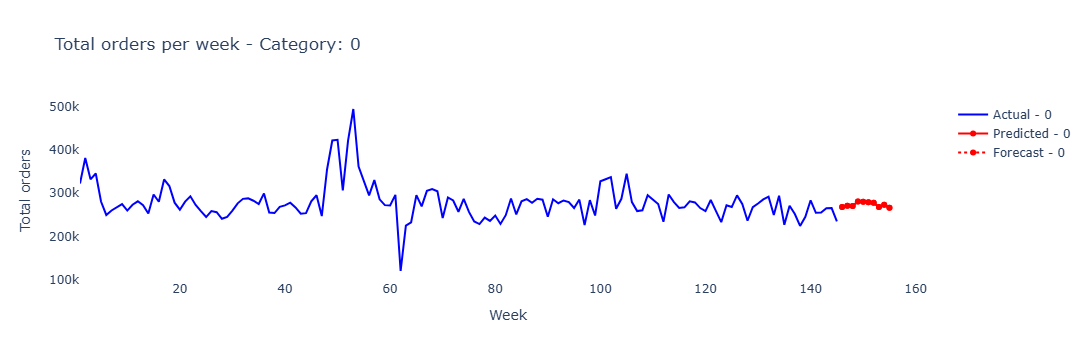

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


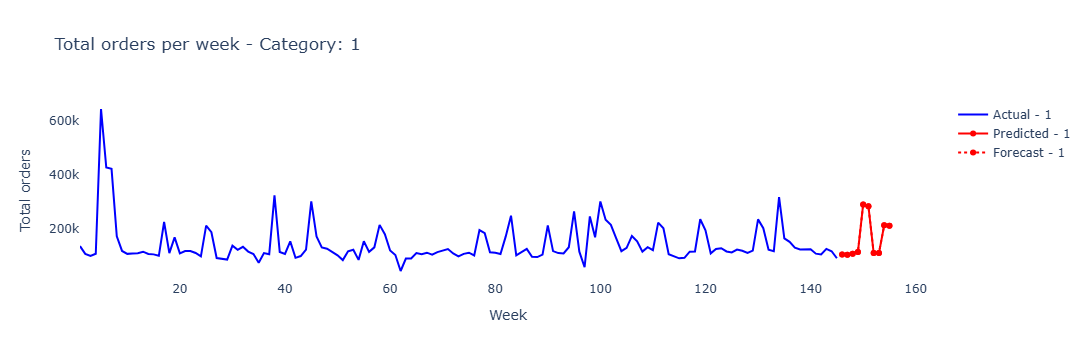

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


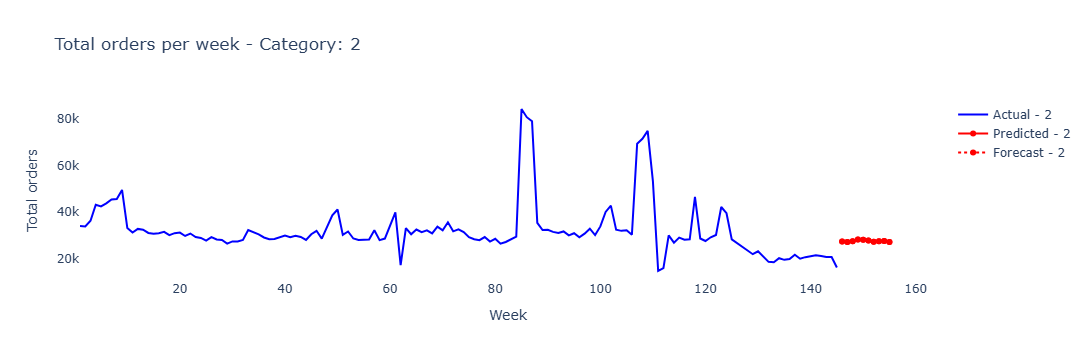

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


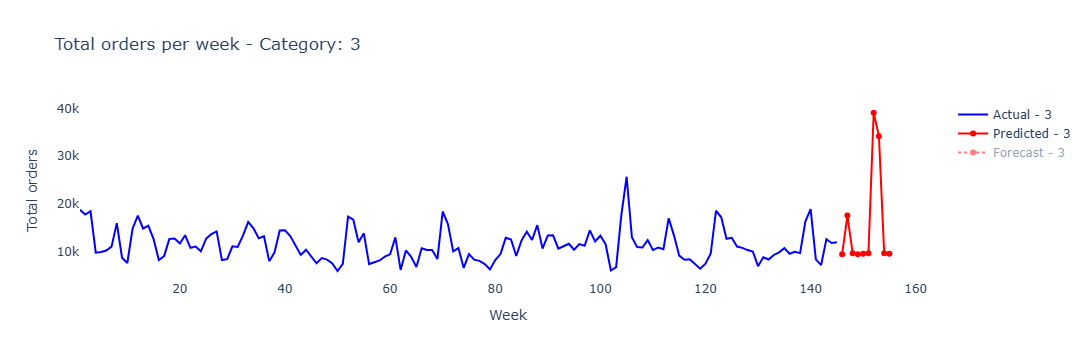

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


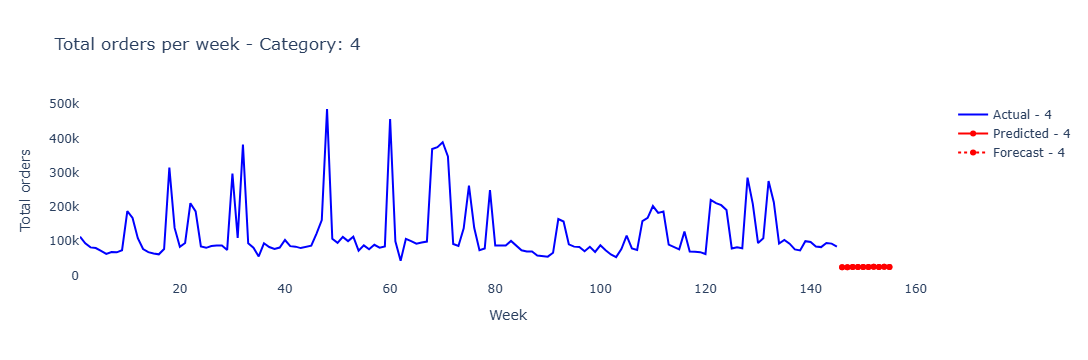

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


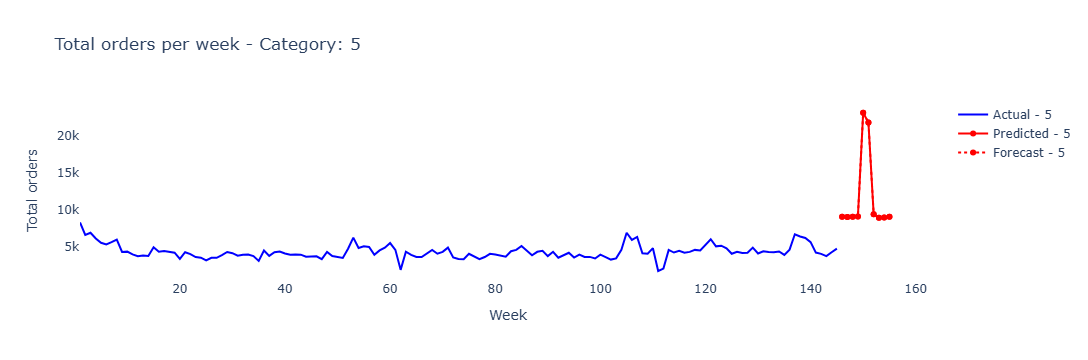

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


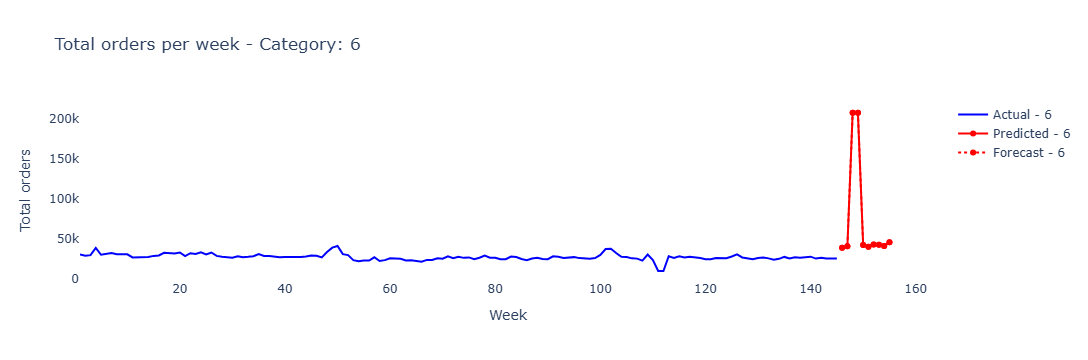

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


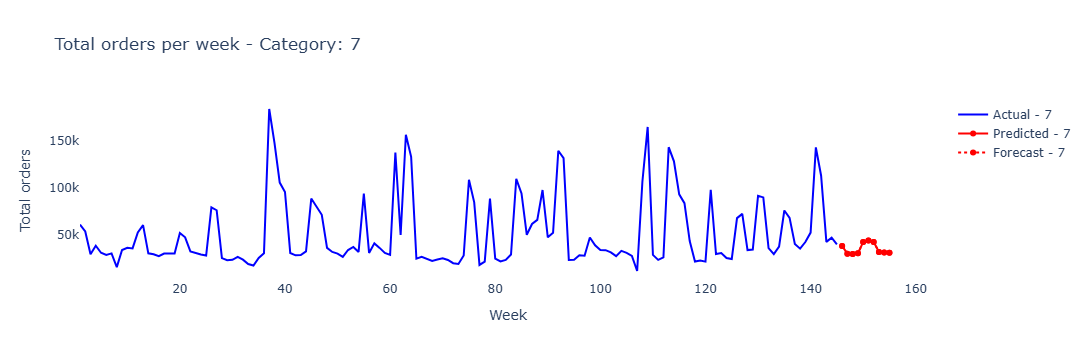

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


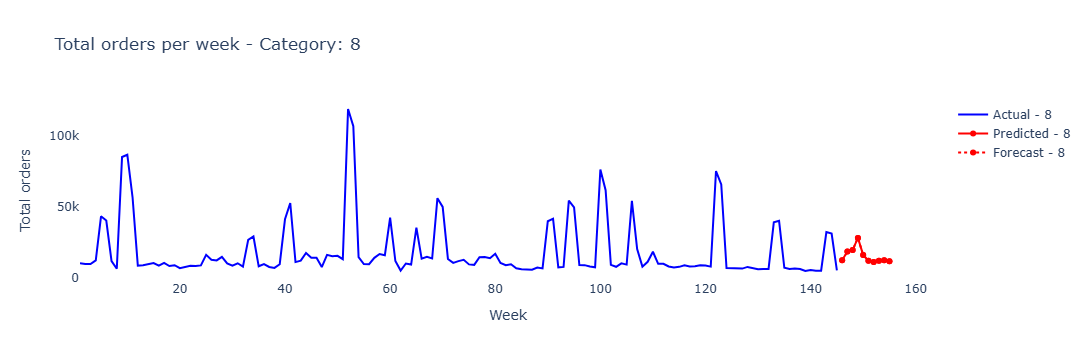

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


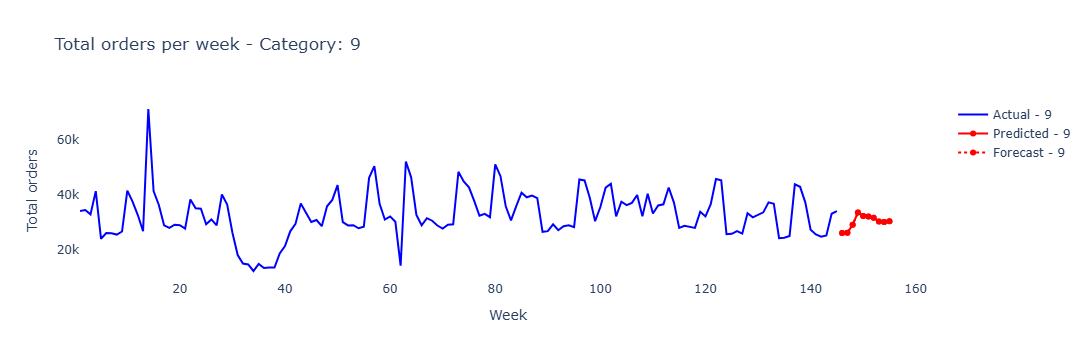

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


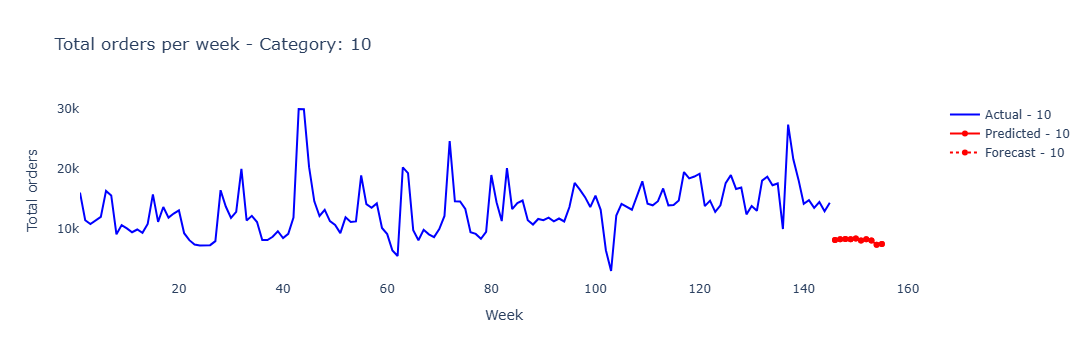

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


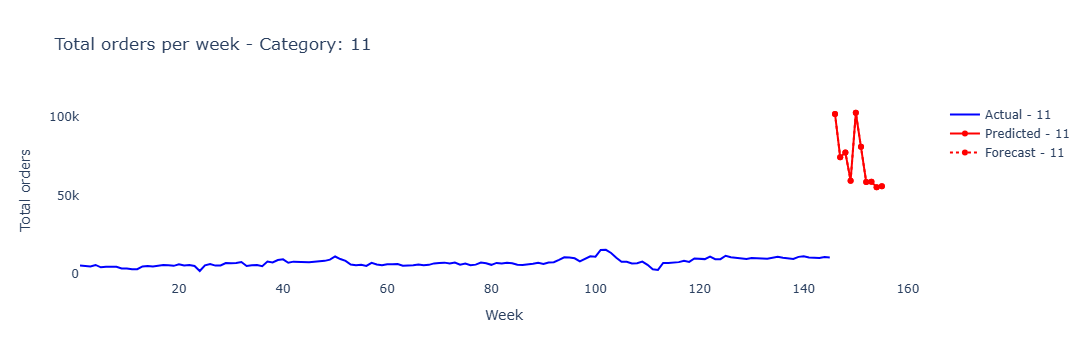

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


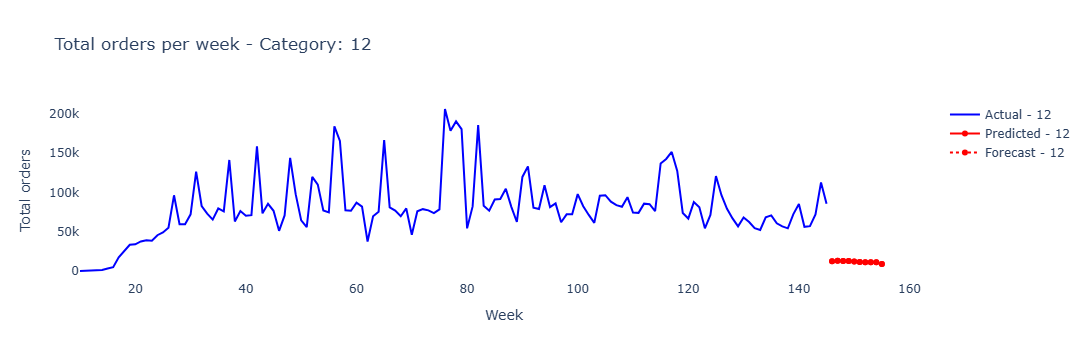

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


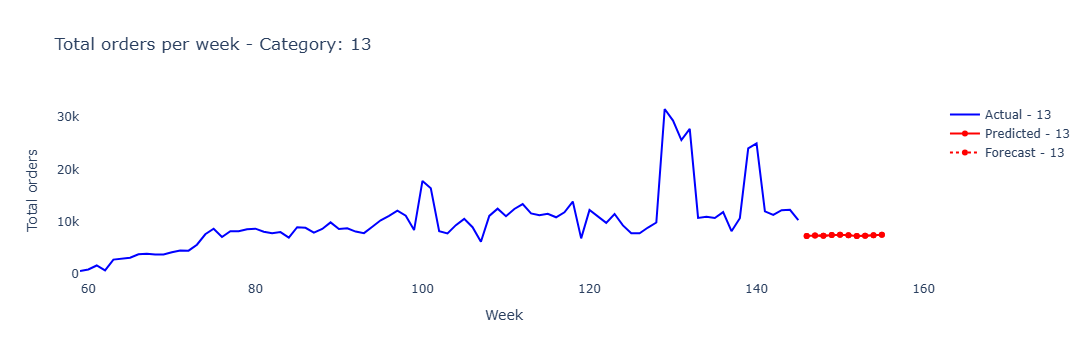

In [12]:
categories = ts_cat_actual['category'].unique()
for category in categories:
    forecast_values = model.predict(test_reshaped[:len(ts_cat_pred[ts_cat_pred['category'] == category])]).flatten()
    forecast_weeks = ts_cat_pred[ts_cat_pred['category'] == category]['week']
    
    plot_data = [
        go.Scatter(
            x=ts_cat_actual[ts_cat_actual['category'] == category]['week'],
            y=ts_cat_actual[ts_cat_actual['category'] == category]['num_orders'],
            name=f'Actual - {category}',
            line=dict(color='Blue')
        ),
        go.Scatter(
            x=ts_cat_pred[ts_cat_pred['category'] == category]['week'],
            y=ts_cat_pred[ts_cat_pred['category'] == category]['num_orders'],
            name=f'Predicted - {category}',
            line=dict(color='Red')
        ),
        go.Scatter(
            x=np.concatenate([forecast_weeks]),
            y=np.concatenate([ts_cat_pred[ts_cat_pred['category'] == category]['num_orders'], forecast_values]),
            name=f'Forecast - {category}',
            line=dict(color='Red', dash='dot')
        )
    ]

    plot_layout = go.Layout(
        title=f'Total orders per week - Category: {category}',
        yaxis_title='Total orders',
        xaxis_title='Week',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig = go.Figure(data=plot_data, layout=plot_layout)
    pyoff.iplot(fig)
